In [1]:
import pandas as pd
#import janitor as jn

In [2]:
pd.set_option('max_columns', None)

## Charger les données

In [32]:
data = pd.read_pickle("../../data/processed/maison.pkl")
#data.to_pickle("../../data/processed/maison.pkl")

In [33]:
# Afficher la table initiale
print(data.info(null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315650 entries, 0 to 315649
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   valeur_fonciere            315650 non-null  float64 
 1   adresse_code_voie          315650 non-null  category
 2   code_postal                315650 non-null  category
 3   code_commune               315650 non-null  category
 4   code_departement           315650 non-null  category
 5   surface_reelle_bati        315650 non-null  float64 
 6   nombre_pieces_principales  315650 non-null  float64 
 7   code_nature_culture        315650 non-null  category
 8   surface_terrain            315650 non-null  float64 
dtypes: category(5), float64(4)
memory usage: 14.1 MB
None


## Traitement des données

In [34]:
num_features = data.select_dtypes("float").columns
categ_features = data.select_dtypes("category").columns

In [35]:
data[categ_features] = data[categ_features].astype("str")
data[num_features] = data[num_features].astype("float32")
#data[["surface_terrain","valeur_fonciere"]] = data[["surface_terrain","valeur_fonciere"]].astype("float32")

In [36]:
data.replace([np.inf, -np.inf], np.nan).dropna(how="any",inplace=True)

In [37]:
data.describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain
count,3.156500e+05,315650.000000,315650.000000,315650.000000
mean,2.590868e+05,97.899345,4.162534,539.635437
std,1.715642e+06,40.304310,1.428083,1275.445190
min,1.600000e-01,1.000000,0.000000,1.000000
25%,1.040000e+05,73.000000,3.000000,217.000000
50%,1.690000e+05,91.000000,4.000000,419.000000
75%,2.624038e+05,116.000000,5.000000,677.000000
max,4.000000e+08,820.000000,67.000000,454660.000000


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315650 entries, 0 to 315649
Data columns (total 9 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   valeur_fonciere            315650 non-null  float32
 1   adresse_code_voie          315650 non-null  object 
 2   code_postal                315650 non-null  object 
 3   code_commune               315650 non-null  object 
 4   code_departement           315650 non-null  object 
 5   surface_reelle_bati        315650 non-null  float32
 6   nombre_pieces_principales  315650 non-null  float32
 7   code_nature_culture        315650 non-null  object 
 8   surface_terrain            315650 non-null  float32
dtypes: float32(4), object(5)
memory usage: 16.9+ MB


In [39]:
#data["code_postal"] = data["code_postal"].astype("str")
cat_f_to_keep = ["code_postal"]
cat_f_to_ignore = categ_features[categ_features!=cat_f_to_keep[0]]

target = 'valeur_fonciere'

num_f_to_keep = list(num_features[num_features!=target])

In [40]:
sub_pc = (data["code_postal"].value_counts().cumsum()<50000)
list_sub_pc = list(sub_pc.index[sub_pc])
df = data[data["code_postal"].isin(list_sub_pc)]

#df = df[(df["valeur_fonciere"]>30000) & (df["valeur_fonciere"]<300000)]
print(data.shape, df.shape, sub_pc.sum())

(315650, 9) (49845, 9) 158


<AxesSubplot:>

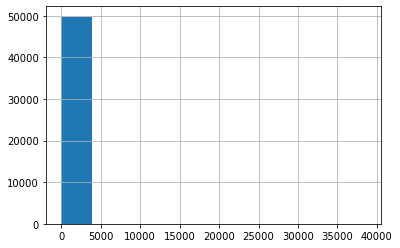

In [41]:
df["surface_terrain"].hist()

In [43]:
#len(list_sub_pc)
sub_pc.index[1]

'72000'

In [122]:
data["code_postal"].isin(list_sub_pc).sum()

99928

In [117]:
pd.DataFrame([data["code_postal"].value_counts(), data["code_postal"].value_counts().cumsum()]).T

,code_postal,code_postal
59200,944,944
72000,790,1734
79000,653,2387
49300,618,3005
59100,613,3618
...,...,...
12540,1,315646
73320,1,315647
74650,1,315648
14380,1,315649


In [120]:
allo[444]

142

In [112]:
df["code_postal"].value_counts().shape

(361,)

In [16]:
df = data[(data["valeur_fonciere"]>30000) & (data["valeur_fonciere"]<300000)]
print(data.shape, df.shape)

(315650, 9) (243287, 9)


## Pycaret - Regression

PROB : pour la scission des données, faire proportionnel dans chaque classe. Mais il y a peut-etre des classes manquantes dans les données d'entrainement que l'on a seulement dans l'ensemble de test.

In [30]:
from pycaret.regression import *

In [42]:
exp_reg101 = setup(data = df, target = target, ignore_features=cat_f_to_ignore, categorical_features=cat_f_to_keep,
                   numeric_features=num_f_to_keep,
                   remove_outliers=True, #remove_multicollinearity = True,# multicollinearity_threshold = 0.6,
                   #combine_rare_levels = True, rare_level_threshold=0.2,
                   feature_selection=True,
                   polynomial_features = True,
                   trigonometry_features = True,
                   feature_interaction=True,
                   feature_ratio=True,
                   create_clusters=True,
                   use_gpu=True,
                   normalize = True, normalize_method="robust", transformation = True, transform_target = True, verbose=True, session_id=123)
# normalize_method='robust'

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,True
2,Transform Target Method,box-cox
3,Original Data,"(49845, 9)"
4,Missing Values,False
5,Numeric Features,5
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
# exp_reg101 = setup(data = data, target = 'valeur_fonciere', remove_outliers=True,
#                    ignore_features=cat_features, create_clusters=True, polynomial_features=True, feature_ratio=True, 
#                    profile=True, session_id=123) 
# exp_reg101 = setup(data = data, target = target, remove_outliers=True, categorical_features=cat_f_tokeep,
#                    numeric_features=num_f_tokeep, ignore_features=cat_f_toignore,
#                    session_id=123) 

In [44]:
compare_models(exclude=["catboost", "svm", "et", "tr", "rf", "ransac", "gbr","ada"], round=4, fold=5, n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,K Neighbors Regressor,176109.0875,3163516252979.2002,1735341.2250,0.1133,0.6898,67.2653,0.7226
1,Extreme Gradient Boosting,143395.8266,3172454262374.3999,1738768.4250,0.1061,0.5374,65.4759,8.2455
2,Light Gradient Boosting Machine,144139.6082,3341844094676.2651,1787805.8816,0.0548,0.5331,67.7124,1.9073
3,Linear Regression,142700.7708,3482664054202.2383,1829146.4349,0.0068,0.5385,74.5597,0.1246
4,Ridge Regression,142597.0096,3484202158948.1377,1829560.0935,0.0063,0.5380,74.0281,0.0682
5,Bayesian Ridge,142571.6453,3484712617014.4692,1829698.9832,0.0061,0.5380,73.8348,0.2661
6,Orthogonal Matching Pursuit,163531.5181,3503157335857.0361,1834632.3373,0.0007,0.6282,77.8808,0.0834
7,Huber Regressor,176218.4974,3514885380036.0186,1838131.9657,-0.0036,0.6801,68.0086,5.2740
8,Lasso Regression,191748.9021,3515940226174.4297,1838549.7486,-0.0042,0.7545,89.1524,0.0783
9,Elastic Net,191752.4443,3515935475313.5625,1838547.9460,-0.0042,0.7545,89.1534,0.0706


[KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform'),
 XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='reg:squarederror', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=0),
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20,

In [69]:
llar = create_model("llar")
#mlp = create_model("mlp")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8025.4898,88335445.6619,9398.6938,-0.0017,0.1955,0.1714
1,8739.1465,103111072.1829,10154.3622,-0.0023,0.2135,0.1896
2,8482.8222,96722925.6564,9834.7814,-0.0024,0.2060,0.1830
3,8374.1796,96363377.2081,9816.4850,-0.0089,0.2073,0.1833
4,8989.7051,106750816.3840,10332.0287,-0.0013,0.2169,0.1946
5,8192.9627,91974081.8524,9590.3119,-0.0046,0.2000,0.1757
6,8230.2312,94562709.1360,9724.3359,-0.0124,0.2065,0.1813
7,8355.5675,94493095.6245,9720.7559,-0.0001,0.2018,0.1778
8,8248.2861,96699064.2293,9833.5682,-0.0126,0.2104,0.1835
9,8601.5701,100793998.7163,10039.6214,-0.0001,0.2104,0.1852


In [71]:
tune_llar = tune_model(llar, n_iter=1000)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,7962.9701,87934676.2779,9377.3491,0.0029,0.1944,0.1691
1,8711.0878,104271863.5207,10211.3595,-0.0136,0.2142,0.1886
2,8307.5918,94399306.3199,9715.9305,0.0216,0.2030,0.1785
3,8220.5521,95984529.4829,9797.1695,-0.0050,0.2061,0.1787
4,8813.9824,103535124.0452,10175.2211,0.0289,0.2140,0.1913
5,8075.4124,93169897.1800,9652.4555,-0.0177,0.2002,0.1726
6,7918.4959,90927423.4377,9535.5872,0.0265,0.2030,0.1754
7,8277.4723,93652413.8169,9677.4177,0.0088,0.2008,0.1760
8,8174.1351,97327459.7908,9865.4680,-0.0192,0.2106,0.1819
9,8685.5187,104572202.7266,10226.0551,-0.0376,0.2130,0.1860


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

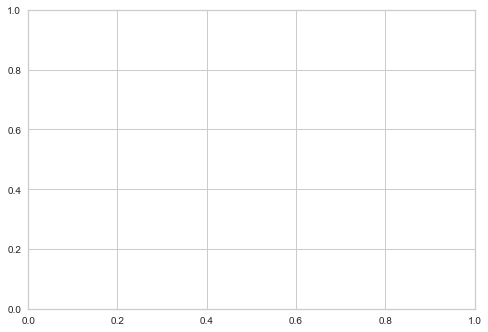

In [64]:
evaluate_model(tune_llar)

In [65]:
tune_mlp = tune_model(mlp, n_iter=100)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,8027.2832,88221041.3812,9392.6057,-0.0004,0.1951,0.1707
1,8742.2812,102881007.7754,10143.0275,-0.0001,0.2125,0.1883
2,8496.1658,96496219.1724,9823.2489,-0.0001,0.2051,0.1819
3,8374.8033,96202361.0816,9808.2802,-0.0072,0.2070,0.1830
4,9045.3681,107321105.8508,10359.5900,-0.0066,0.2149,0.1912
5,8168.1593,91676555.1442,9574.7875,-0.0014,0.1992,0.1742
6,8257.3186,95599968.2532,9777.5236,-0.0235,0.2082,0.1832
7,8365.4265,94496780.9201,9720.9455,-0.0002,0.2014,0.1772
8,8251.1683,96993346.2266,9848.5200,-0.0157,0.2109,0.1840
9,8607.1335,100781941.2388,10039.0209,-0.0000,0.2102,0.1849


In [73]:
pm = predict_model(tune_llar)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Lasso Lars,8305.4855,9.435857e+07,9713.834,0.0356,0.2035,0.1793


In [77]:
pm.sort_values(by="Label",ascending=False)

,code_postal_76140.0,code_postal_30190.0,code_postal_85600.0,code_postal_76600.0,code_postal_30700.0,code_postal_8300.0,code_postal_44160.0,code_postal_76400.0,code_postal_44450.0,code_postal_29260.0,...,nombre_pieces_principales_multiply_data_cluster_0,surface_terrain_Power2_multiply_code_postal_81200.0,surface_reelle_bati_multiply_data_cluster_0,code_postal_80300.0_multiply_nombre_pieces_principales_Power2,data_cluster_1_multiply_cos(surface_terrain),nombre_pieces_principales_Power2_divide_surface_reelle_bati,surface_terrain_Power2_multiply_code_postal_59200.0,surface_terrain_multiply_surface_terrain_Power2,0,Label
938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.134335,0.000000,0.398671,-0.0,-0.000000,-0.384511,0.0,0.593921,62016.007812,58574.0648
1742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.854470,2.571631,0.0,1.310693,49984.007812,58140.5702
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.378944,1.540529,0.0,0.112940,64992.003906,58136.0858
538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.520186,0.447671,0.0,2.600609,64992.003906,58053.1144
1723,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.000000,0.000000,0.0,1.406762,85513.901227,-0.0,-0.012245,35008.003906,57927.9236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.134335,0.000000,-0.922594,-0.0,-0.000000,0.166155,0.0,2.021090,55008.003906,44348.9329
482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.134335,-1.054684,-0.122058,-0.0,0.000000,1.255905,-0.0,1.303450,32000.003906,43708.1153
1804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.008948,0.000000,-0.768580,-0.0,0.000000,1.438158,0.0,0.060684,52000.003906,43482.3539
1565,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.134335,-0.000000,-0.122058,-0.0,0.000000,1.255905,-0.0,0.901085,60000.003906,43473.1141


In [54]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model.Lasso,True
ridge,Ridge Regression,sklearn.linear_model.Ridge,True
en,Elastic Net,sklearn.linear_model.ElasticNet,True
lar,Least Angle Regression,sklearn.linear_model.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model.OMP,True
br,Bayesian Ridge,sklearn.linear_model.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model.ARDRegression,False


## Un seul code postal

In [59]:
categ_features

Index(['adresse_code_voie', 'code_postal', 'code_commune', 'code_departement',
       'code_nature_culture'],
      dtype='object')

In [63]:
data["adresse_code_voie"]

0         0125
1         0375
2         0060
3         0190
4         0270
          ... 
315645    0120
315646    0066
315647    0259
315648    0330
315649    0134
Name: adresse_code_voie, Length: 315650, dtype: object

In [64]:
#data["code_postal"] = data["code_postal"].astype("str")
cat_f_to_keep = ["adresse_code_voie"]
cat_f_to_ignore = ["code_postal","code_commune"]

target = 'valeur_fonciere'

num_f_to_keep = list(num_features[num_features!=target])

sub_pc = data["code_postal"].value_counts()
list_sub_pc = sub_pc.index[0]
print(list_sub_pc)
df2 = data[data["code_postal"].isin([list_sub_pc])]

df2 = df2[(df2["valeur_fonciere"]>30000) & (df2["valeur_fonciere"]<300000)]
print(data.shape, df2.shape, sub_pc.sum(), list_sub_pc)

59200
(315650, 9) (887, 9) 315650 59200


In [66]:
exp_un_1 = setup(data = df2, target = target, ignore_features=cat_f_to_ignore, categorical_features=cat_f_to_keep,
                   numeric_features=num_f_to_keep,
                   remove_outliers=True, #remove_multicollinearity = True,# multicollinearity_threshold = 0.6,
                   #combine_rare_levels = True, rare_level_threshold=0.2,
                   feature_selection=True,
                   polynomial_features = True,
                   trigonometry_features = True,
                   feature_interaction=True,
                   feature_ratio=True,
                   create_clusters=True,
                   use_gpu=True,
                   normalize = True, normalize_method="robust", transformation = True, transform_target = True, verbose=True, session_id=123)
# normalize_method='robust'

 
Setup Succesfully Completed.


,Description,Value
0,session_id,123
1,Transform Target,True
2,Transform Target Method,box-cox
3,Original Data,"(887, 9)"
4,Missing Values,False
5,Numeric Features,3
6,Categorical Features,5
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [67]:
compare_models(round=4, fold=5, n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,33565.6798,1873091566.1455,43182.3267,0.2631,0.3379,0.2908,3.9087
1,CatBoost Regressor,33871.6444,1901561768.1731,43516.4012,0.2527,0.3437,0.2952,73.2293
2,Random Forest,33994.9846,1927984915.7232,43865.0794,0.2402,0.3451,0.2968,2.3578
3,Support Vector Machine,33842.5272,1954574148.7029,44164.2094,0.2305,0.3501,0.3048,1.6416
4,AdaBoost Regressor,34248.3122,1989843899.2476,44484.3460,0.2142,0.3445,0.2898,3.7911
5,Bayesian Ridge,33602.0796,2003859735.4108,44678.8054,0.2107,0.3457,0.2930,3.5270
6,K Neighbors Regressor,35350.7234,2042460979.2000,45172.3773,0.1945,0.3559,0.3074,0.2876
7,Extra Trees Regressor,35238.6756,2071224827.2562,45459.0042,0.1850,0.3634,0.3136,3.3529
8,Light Gradient Boosting Machine,36352.0515,2131104051.0252,46132.4827,0.1588,0.3614,0.3126,0.3937
9,Extreme Gradient Boosting,36618.9555,2216280115.2000,47011.8086,0.1271,0.3712,0.3164,4.7517


[GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                           init=None, learning_rate=0.1, loss='ls', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_sp

In [68]:
gbr = create_model("gbr")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,31765.4817,1967804869.7112,44359.9467,0.1728,0.3661,0.3018
1,36313.9541,2023527292.0921,44983.6336,0.1445,0.3797,0.3543
2,30705.0266,1448292494.3986,38056.4383,0.3513,0.3289,0.2901
3,28766.5281,1380332531.3741,37152.8267,0.4571,0.2795,0.2399
4,31900.1592,1725070164.3945,41533.9640,0.2843,0.3176,0.2500
5,33983.0880,2390258629.5162,48890.2713,0.3024,0.3265,0.2521
6,32449.2199,1610660722.3643,40133.0378,0.2744,0.3437,0.3071
7,35190.8101,2156303789.8766,46436.0182,0.2076,0.3347,0.2762
8,31820.5175,1605410640.6650,40067.5759,0.2159,0.3067,0.2599
9,35198.8067,1968324110.8326,44365.7989,0.3547,0.3586,0.3268


In [69]:
tuned_gbr = tune_model(gbr, n_iter)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,34930.3983,2053387864.9795,45314.3230,0.1368,0.3773,0.3218
1,36584.9258,2077879341.6829,45583.7618,0.1215,0.3825,0.3507
2,32167.3785,1729678009.8407,41589.3978,0.2253,0.3450,0.3029
3,34829.7779,1802095325.4607,42451.0933,0.2912,0.3254,0.2827
4,35607.3126,2115288824.5187,45992.2692,0.1223,0.3538,0.2970
5,38914.1977,2789659097.2599,52817.2235,0.1859,0.3469,0.2849
6,38048.3749,2011564491.5493,44850.4681,0.0939,0.3737,0.3415
7,37037.3515,2413173511.0270,49124.0624,0.1132,0.3616,0.2901
8,35710.1508,2109783278.6232,45932.3772,-0.0304,0.3577,0.3015
9,38553.0128,2473733316.0818,49736.6396,0.1889,0.3999,0.3527


In [70]:
evaluate_model(tuned_gbr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Restes

In [ ]:
interpret_model(xg_reg)

In [ ]:
xg_reg = automl(use_holdout=False)
xg_reg

In [ ]:
plot_model(xg_reg, plot = 'residuals')

In [ ]:
pull()

In [ ]:
xg_reg = create_model("xgboost")
tune_xg_reg = tune_model(xg_reg, n_iter=100, fold=10, choose_better=True)
print(tune_xg_reg)

In [ ]:
tune_xg_reg2 = tune_model(tune_xg_reg2, n_iter=10, fold=10, choose_better=True)
print(tune_xg_reg)

In [ ]:
print(tune_xg_reg2)

In [ ]:
finalize_model(xg_reg)

In [ ]:
save_model(xg_reg,'../../models/final_xg_reg_for_streamlit_test')

In [ ]:
predict_model(xg_reg)

In [ ]:
interpret_model(xg_reg)

In [ ]:
rf_reg = create_model("rf")
tune_rf_reg = tune_model(rf_reg, n_iter=100, fold=10, choose_better=True)
print(tune_rf_reg)

In [ ]:
compare_models(whitelist=["catboost", "svm"], fold=5, n_select=2)

In [ ]:
compare_models(blacklist=["catboost"], fold=5, n_select=1)

In [ ]:
catboost_reg = create_model("catboost")

In [ ]:
tune_huber_reg = tune_model(huber_reg, n_iter=100, fold=10, choose_better=True)
print(tune_huber_reg)

In [ ]:
#evaluate_model(tune_huber_reg)

In [ ]:
interpret_model(tune_huber_reg)

In [ ]:
exp_reg102 = setup(data = data, target = 'valeur_fonciere', remove_outliers=True,
                   ignore_features=cat_features, polynomial_features=True,
                   session_id=124) 

In [ ]:
compare_models(blacklist=["catboost","svm"], fold=5, n_select=1)

In [ ]:
lr_reg = create_model("lr")

In [ ]:
tune_lr_reg = tune_model(lr_reg, n_iter=100, fold=10, choose_better=True)
print(tune_lr_reg)

In [ ]:
interpret_model(tune_lr_reg)

In [ ]:
blend_all = blend_models()

In [ ]:
data["code_postal"] = data["code_postal"].apply(lambda x: f"{x}")

In [ ]:
data["code_postal"]

In [ ]:
pd.Series.apply()